## Input setup and global constants

In [ ]:
import time
import numpy as np
import pandas as pd
from gurobipy import Model, GRB

from Input_generator import generate_input  # must be in the same folder or on PYTHONPATH

# --- Constants ---
FEAS_PENALTY   = 1e6   # penalty for violating storage bounds (per 10^3 m^3)
GAMMA          = 1.0   # discount factor
MAX_ITERS      = 30    # SDDP iterations (backward sweeps)
BACKWARD_BATCH = 30    # samples per stage per backward sweep
OUT_PREFIX     = "run" # CSV filename prefix
VERBOSE        = False # small logs in backward pass


## Cut utilities (upper envelope)

Cuts represent the post-decision value approximation 
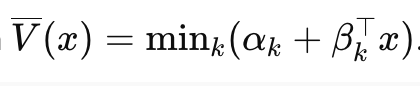

What this does: evaluates/creates cuts and computes a local supporting cut via finite differences.

In [16]:
def eval_cuts(cuts_list, x):
    """
    Evaluate the post-decision value approximation Vbar(x) = min_k (alpha_k + beta_k^T x).
    Assumes cuts_list is non-empty (we seed it in initialization).
    """
    vals = [c["alpha"] + float(np.dot(c["beta"], x)) for c in cuts_list]
    return min(vals)

def add_cut(cuts_list, alpha, beta):
    """
    Append one cut α + β^T x. Each cut is stored as {"alpha": float, "beta": np.ndarray}.
    """
    cuts_list.append({"alpha": float(alpha), "beta": np.array(beta, dtype=float)})

def finite_diff_subgrad(eval_fn, x0, h=1e-3):
    """
    Simple numerical subgradient of Vbar at x0.
    Returns (alpha, g) so that alpha + g^T x is tight at x0 and upper-bounds locally.
    """
    x0 = np.array(x0, dtype=float)
    base = eval_fn(x0)
    g = np.zeros_like(x0)
    for j in range(len(x0)):
        z = x0.copy(); z[j] += h
        g[j] = (eval_fn(z) - base) / h
    alpha = base - np.dot(g, x0)
    return alpha, g


## Stage LP builder + safe solver

Canonical LP used in both backward and forward passes. We enforce θ ≤ cuts and add storage slack penalties for feasibility.

What this does: defines the optimization problem solved at each stage and a wrapper that solves it and reads results safely.

In [17]:
def build_stage_lp(m, J, t, price_t, l_prev, inflow_t,
                   l_min, l_max, pi_min, pi_max, alpha_energy,
                   cuts_next, gamma=GAMMA, feas_penalty=FEAS_PENALTY):
    """
    Decisions:
      pi[j]  : discharge
      l[j]   : end-of-stage storage
      x[j]   : post-decision storage (before inflow) = l_prev - pi
      s_lo/j,s_up/j : soft slacks for storage bounds (>=0)
      theta  : future value proxy, upper-bounded by next-stage cuts

    Constraints:
      x = l_prev - pi
      l = x + inflow
      l >= l_min - s_lo     (soft lower bound)
      l <= l_max + s_up     (soft upper bound)
      theta <= alpha_k + beta_k^T x  for all cuts in 'cuts_next'
    Objective: maximize revenue + gamma*theta - FEAS_PENALTY * (sum of slacks).
    """
    # Variables
    pi    = [m.addVar(lb=float(pi_min[j]), ub=float(pi_max[j]), name=f"pi_{j}_{t}") for j in range(J)]
    l     = [m.addVar(lb=-GRB.INFINITY,     ub=GRB.INFINITY,     name=f"l_{j}_{t}")  for j in range(J)]
    x     = [m.addVar(lb=-GRB.INFINITY,     ub=GRB.INFINITY,     name=f"x_{j}_{t}")  for j in range(J)]
    s_lo  = [m.addVar(lb=0.0,               ub=GRB.INFINITY,     name=f"slo_{j}_{t}") for j in range(J)]
    s_up  = [m.addVar(lb=0.0,               ub=GRB.INFINITY,     name=f"sup_{j}_{t}") for j in range(J)]
    theta = m.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name=f"theta_{t}")

    # Linking + mass balance + soft bounds
    for j in range(J):
        m.addConstr(x[j] == float(l_prev[j]) - pi[j],          name=f"xdef_{j}_{t}")
        m.addConstr(l[j] == x[j] + float(inflow_t[j]),         name=f"mb_{j}_{t}")
        m.addConstr(l[j] >= float(l_min[j]) - s_lo[j],         name=f"lb_{j}_{t}")
        m.addConstr(l[j] <= float(l_max[j]) + s_up[j],         name=f"ub_{j}_{t}")

    # Future value proxy (upper-bounded by cuts for next stage)
    for k, cut in enumerate(cuts_next):
        m.addConstr(
            theta <= float(cut["alpha"]) + sum(float(cut["beta"][j]) * x[j] for j in range(J)),
            name=f"cut_{t+1}_{k}"
        )

    # Objective: current revenue + discounted theta - penalties on slacks
    revenue = sum(price_t * alpha_energy[j] * pi[j] for j in range(J))
    penalty = feas_penalty * sum(s_lo[j] + s_up[j] for j in range(J))
    m.setObjective(revenue + gamma * theta - penalty, GRB.MAXIMIZE)

    return {"pi": pi, "l": l, "x": x, "s_lo": s_lo, "s_up": s_up, "theta": [theta]}

def solve_stage_lp(build_fn, *args, **kwargs):
    """
    Build a fresh model, optimize, and safely read variable values.
    """
    m = Model()
    m.Params.OutputFlag = 0
    m.Params.DualReductions = 0  # clearer infeasible/unbounded flags

    varbags = build_fn(m, *args, **kwargs)
    m.optimize()

    if m.SolCount == 0:
        raise RuntimeError(f"No solution (status={m.Status})")

    sol = {}
    for name, varlist in varbags.items():
        vals = m.getAttr("X", varlist)
        sol[name] = [float(v) for v in vals]
    return m.ObjVal, sol


## Backward pass (cut generation)

What this does: enriches the value function approximation by adding cuts at each stage.

In [18]:
def backward_pass(J, T, prices, inflows, l_min, l_max, pi_min, pi_max,
                  alpha_energy, cuts, gamma=GAMMA, batch=BACKWARD_BATCH):
    """
    For t = T..1:
      - sample 'batch' scenarios at stage t,
      - solve the stage LP using current cuts at t+1,
      - take a finite-difference subgradient around the optimal x (post-decision),
      - append a new cut for Vbar_t.
    """
    N = inflows.shape[0]
    for t in range(T, 0, -1):
        cuts_next = cuts[t]                       # Vbar_{t+1}
        price_t = float(np.mean(prices[:, t-1]))  # use stage mean price here
        idx = np.random.choice(N, size=min(batch, N), replace=False)

        for n in idx:
            l_prev = 0.5 * (l_min + l_max)        # representative pre-decision storage
            inflow_t = inflows[n, t-1, :]

            obj, sol = solve_stage_lp(
                build_stage_lp,
                J, t, price_t, l_prev, inflow_t,
                l_min, l_max, pi_min, pi_max, alpha_energy,
                cuts_next, gamma, FEAS_PENALTY
            )
            xpost = np.array(sol["x"], dtype=float)

            # Build supporting cut for Vbar_t from Vbar_{t+1} near xpost
            eval_fn = lambda z: eval_cuts(cuts_next, np.array(z, dtype=float))
            alpha_new, beta_new = finite_diff_subgrad(eval_fn, xpost)
            add_cut(cuts[t-1], alpha_new, beta_new)

        if VERBOSE:
            print(f"[Backward] t={t} -> |cuts_t| = {len(cuts[t-1])}")

    return cuts


## Forward pass (policy rollout & logging)

Simulate the learned policy to produce the CSV data for figures/tables.

What this does: solves the stage LP along sampled paths, logs decisions/states/values, and captures the first-hour value-function numbers.

In [19]:
def forward_pass_collect(J, T, prices, inflows, l0, l_min, l_max, pi_min, pi_max,
                         alpha_energy, cuts, gamma=GAMMA, N_paths=100, seed=0):
    """
    Roll out the current policy on N_paths scenario indices and
    log per-stage variables and values (including first-hour numbers).
    Returns:
      df_stage: per-stage rows for all paths,
      df_first: one row per path with first-hour value-function quantities.
    """
    rng = np.random.default_rng(seed)
    N_total = inflows.shape[0]
    choice = rng.choice(N_total, size=N_paths, replace=True)

    stage_rows, first_rows = [], []

    for p, n in enumerate(choice):
        l_prev = np.array(l0, dtype=float)
        total_obj = 0.0

        for t in range(1, T + 1):
            price_t = float(prices[n, t-1])
            inflow_t = inflows[n, t-1, :].astype(float)

            obj, sol = solve_stage_lp(
                build_stage_lp,
                J, t, price_t, l_prev, inflow_t,
                l_min, l_max, pi_min, pi_max, alpha_energy,
                cuts[t], gamma, FEAS_PENALTY
            )

            pi_vals   = np.array(sol["pi"],   dtype=float)
            l_vals    = np.array(sol["l"],    dtype=float)
            x_vals    = np.array(sol["x"],    dtype=float)
            slo_vals  = np.array(sol["s_lo"], dtype=float)
            sup_vals  = np.array(sol["s_up"], dtype=float)
            theta_val = float(sol["theta"][0])

            rev_stage     = price_t * float(np.dot(alpha_energy, pi_vals))
            penalty_stage = FEAS_PENALTY * float(np.sum(slo_vals + sup_vals))
            util_alg      = rev_stage - penalty_stage
            v_est         = eval_cuts(cuts[t], x_vals)

            if t == 1:
                first_rows.append({
                    "path": p,
                    "theta1": theta_val,
                    "vbar2_at_xpost1": v_est,
                    "price1": price_t,
                    **{f"inflow1_res{j+1}": float(inflow_t[j]) for j in range(J)}
                })

            rec = {
                "path": p, "stage": t,
                "price": price_t,
                "obj_stage": obj,
                "rev_stage": rev_stage,
                "penalty_stage": penalty_stage,
                "util_alg": util_alg,
                "theta": theta_val,
                "v_est": v_est,
            }
            for j in range(J):
                rec[f"pi{j+1}"]     = float(pi_vals[j])
                rec[f"l{j+1}"]      = float(l_vals[j])
                rec[f"xpost{j+1}"]  = float(x_vals[j])
                rec[f"inflow{j+1}"] = float(inflow_t[j])
            stage_rows.append(rec)

            l_prev = l_vals.copy()
            total_obj += obj

        stage_rows.append({"path": p, "stage": "total", "obj_total": total_obj})

    return pd.DataFrame(stage_rows), pd.DataFrame(first_rows)


## One-run wrapper: train → forward → CSV export
Runs SDDP for one N and writes three CSVs: per-stage, first-hour, summary.

What this does: wraps training + evaluation for one N and writes the CSVs your plotting/report code expects.

In [ ]:
def run_sddp_and_export(N=100, max_iters=MAX_ITERS,
                        back_batch=BACKWARD_BATCH,
                        gamma=GAMMA, seed_train=0, seed_oos=999,
                        N_paths=None, out_prefix=OUT_PREFIX):
    """
    Train SDDP on N samples, then forward-simulate and export CSVs.
    Exports:
      {prefix}_N{N}_paths.csv
      {prefix}_N{N}_first_hour.csv
      {prefix}_N{N}_summary.csv
    """
    (J, T, l_max, l_min, l0,
     pi_max, pi_min, price_samples, inflow_samples,
     nu0, rho0, R, a_t, b_t, l_bar, alpha_energy) = generate_input(N)

    if N_paths is None:
        N_paths = N  # export all N paths (can be large)
        
    # Initialize cuts: cuts[t] stores V̄_{t+1} (list of cuts) for index t
    cuts = [[] for _ in range(T + 1)]

    # --- Non-zero terminal salvage ---

    phi = np.mean(price_samples[:, -1]) * alpha_energy  # dollars per unit storage
    add_cut(cuts[T], 0.0, phi)


    # Backward iterations
    t0 = time.time()
    for it in range(1, max_iters + 1):
        cuts = backward_pass(
            J, T, price_samples, inflow_samples,
            l_min, l_max, pi_min, pi_max, alpha_energy,
            cuts, gamma=gamma, batch=back_batch
        )
        if VERBOSE:
            print(f"[Iter {it}/{max_iters}] backward done.")

    # Forward pass (collect detailed stage-level data)
    df_stage, df_first = forward_pass_collect(
        J, T, price_samples, inflow_samples, l0,
        l_min, l_max, pi_min, pi_max, alpha_energy,
        cuts, gamma=gamma, N_paths=N_paths, seed=seed_oos
    )

    # Exports
    base = f"{out_prefix}_N{N}"
    df_stage.to_csv(f"{base}_paths.csv", index=False)
    df_first.to_csv(f"{base}_first_hour.csv", index=False)
    print(f"Exported {base}_paths.csv and {base}_first_hour.csv")

    # Small run summary
    path_totals = df_stage[df_stage["stage"] == "total"]["obj_total"].dropna().values
    df_sum = pd.DataFrame([{
        "N": N,
        "paths": int(np.sum(df_stage["stage"].values == "total")),
        "avg_obj_total": float(np.mean(path_totals)) if path_totals.size else np.nan,
        "p10_obj_total": float(np.percentile(path_totals, 10)) if path_totals.size else np.nan,
        "p50_obj_total": float(np.percentile(path_totals, 50)) if path_totals.size else np.nan,
        "p90_obj_total": float(np.percentile(path_totals, 90)) if path_totals.size else np.nan,
        "runtime_hours": (time.time() - t0) / 3600.0
    }])
    df_sum.to_csv(f"{base}_summary.csv", index=False)
    print(f"Exported {base}_summary.csv")

    return df_stage, df_first, df_sum


## Loop over N = 100…1000 and export everything
Top-level experiment script. Produces a combined summary across all runs.

What this does: runs the whole pipeline for N=100…1000 and saves a per-N trio of CSVs plus one combined summary.

In [21]:
all_summaries = []
N=None
if N==None:
    for N in range(100, 1001, 100):  # 100, 200, ..., 1000
        print(f"\n=== Running SDDP with N={N} samples ===")
        _, _, df_sum = run_sddp_and_export(
            N=N,
            max_iters=MAX_ITERS,
            back_batch=BACKWARD_BATCH,
            gamma=GAMMA,
            seed_train=0,
            seed_oos=999,
            N_paths=N,               # use all N paths; reduce if you only need a few
            out_prefix=OUT_PREFIX
        )
        all_summaries.append(df_sum)
else:
    print(f"\n=== Running SDDP with N={N} samples ===")
    _, _, df_sum = run_sddp_and_export(
                N=N,
                max_iters=MAX_ITERS,
                back_batch=BACKWARD_BATCH,
                gamma=GAMMA,
                seed_train=0,
                seed_oos=999,
                N_paths=N,               # use all N paths; reduce if you only need a few
                out_prefix=OUT_PREFIX
            )
    all_summaries.append(df_sum)
    

# Combine into one CSV for quick tables
df_all = pd.concat(all_summaries, ignore_index=True)
df_all.to_csv(f"{OUT_PREFIX}_summary_allN.csv", index=False)
print(f"\nExported {OUT_PREFIX}_summary_allN.csv")



=== Running SDDP with N=100 samples ===
Exported run_N100_paths.csv and run_N100_first_hour.csv
Exported run_N100_summary.csv

=== Running SDDP with N=200 samples ===
Exported run_N200_paths.csv and run_N200_first_hour.csv
Exported run_N200_summary.csv

=== Running SDDP with N=300 samples ===
Exported run_N300_paths.csv and run_N300_first_hour.csv
Exported run_N300_summary.csv

=== Running SDDP with N=400 samples ===
Exported run_N400_paths.csv and run_N400_first_hour.csv
Exported run_N400_summary.csv

=== Running SDDP with N=500 samples ===
Exported run_N500_paths.csv and run_N500_first_hour.csv
Exported run_N500_summary.csv

=== Running SDDP with N=600 samples ===
Exported run_N600_paths.csv and run_N600_first_hour.csv
Exported run_N600_summary.csv

=== Running SDDP with N=700 samples ===
Exported run_N700_paths.csv and run_N700_first_hour.csv
Exported run_N700_summary.csv

=== Running SDDP with N=800 samples ===
Exported run_N800_paths.csv and run_N800_first_hour.csv
Exported run_N